# Importing and cleaning

In [1]:
import pandas as pd
import graphviz 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sc
import statistics
from sklearn.model_selection import train_test_split
from sklearn import tree
from matplotlib import cm
from sklearn.metrics import silhouette_samples

In [2]:
df = pd.read_csv('C:/Users/Guglielmo/Desktop/AppleStore.csv', sep=',', header=0, index_col=0)

## Cleaning

Dropping the non relevant columns for our analysis. We don't care about the ID, the name of the app, its size, currency (they're all USD), current version, and whatever vpp_lic is (they're all == 1 anyway).

In [3]:
df = df.drop(['id','track_name', 'size_bytes', 'currency', 'ver', 'vpp_lic'], axis = 1)

Dropping the categorical variables.

In [4]:
df_nocat = df.drop(['cont_rating', 'prime_genre'], axis=1)

And storing them for later use.

In [5]:
df_cont = df[['cont_rating']]
df_gen = df[['prime_genre']]

Let's take a look at the data.

In [6]:
#sns.pairplot(df_nocat, diag_kind='kde')
#plt.show()

Not really representative or useful at the moment...

However, we can see from some univariate distributions that there are few outliers. We can remove them in order to prevent our following analyses from being somewhat skewed.

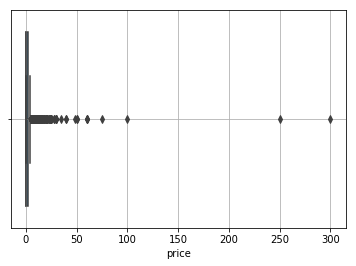

In [7]:
sns.boxplot(df_nocat['price'])
plt.grid()
plt.show()

### Removing outliers

Let's normalize data and transform it in absolute value so that we can identify the outliers (value > 3), that is to say they're above the 3rd standard deviation.

In [8]:
z_score = np.abs(sc.zscore(df_nocat))
# normalizes data, returns absolute value

df_nocat = df_nocat.reset_index(drop=True)
# resets the index of df_nocat, start at 0

rem_row = np.unique(np.where(z_score > 3)[0])
# returns indexes of the rows that have at least
# one z_score > 3

df_nocat_noout = df_nocat.drop(rem_row, axis=0)
# removes rows that contain outliers,
# saves in new dataframe

In [9]:
# sns.pairplot(df_nocat_noout, diag_kind='kde')
# plt.show()

A little better. Now at least univariate distribution of price is something more than a vertical line above the 0 value. Sure, the majority of apps are free, but the previous KDE was unreadable.

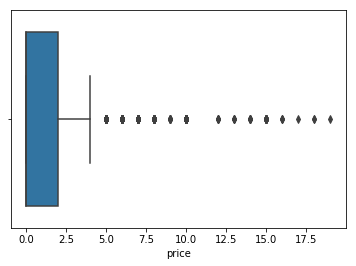

In [10]:
sns.boxplot(df_nocat_noout['price'])
plt.show()

# Starter analysis

## Correlation heatmap

Let's build a correlation heatmap to see if there is any relevant correlation between the variables.

In [11]:
corr = df_nocat_noout.corr()

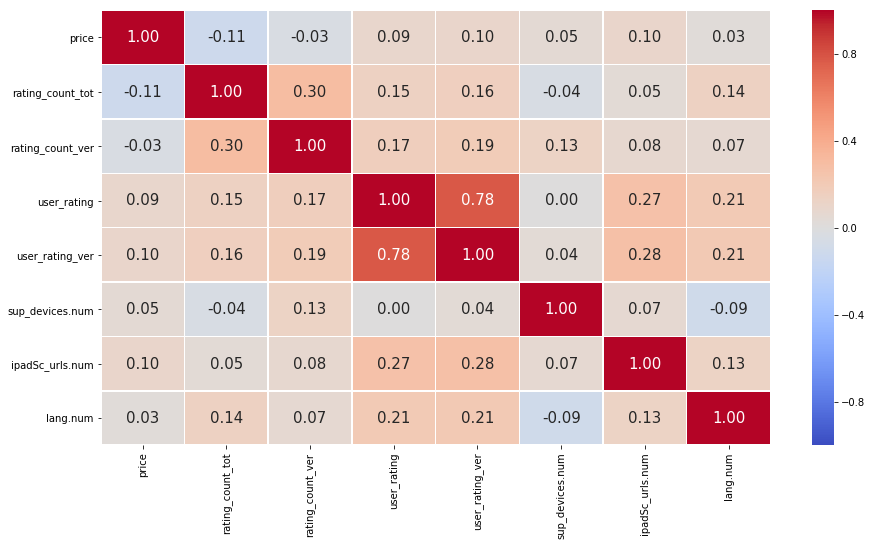

In [12]:
fig, ax = plt.subplots(figsize=(15,8))

hm = sns.heatmap(corr,
                 ax=ax,
                 cmap='coolwarm',
                 vmin=-1.0,
                 vmax=1.0,
                 annot=True,
                 fmt='.2f',
                 annot_kws={'size':15},
                 linewidths=0.5)

There's very low correlations between most attributes, looks like we need go further and use all the variables for our analysis.

Next we'll try to put user rating as "class", drop it from the DF, put back categorical variables, run a decision tree, see results, ????, profit.

## Decision tree

### Setup

We start by adding back the 2 categorical variables that we removed before, of course removing the rows that correspond to outlier data.

In [13]:
df_cont = df_cont.reset_index(drop=True)
df_gen = df_gen.reset_index(drop=True)
# resets the index of content rating and genre attributes, start at 0

df_cont = df_cont.drop(rem_row, axis=0)
df_gen = df_gen.drop(rem_row, axis=0)

# removes rows that contain outliers,
# saves in same dataframe

In [14]:
df_tree = pd.concat([df_nocat_noout, df_cont, df_gen], axis = 1)
#puts back the 2 attribute columns in the dataframe

In [15]:
df_tree['prime_genre'] = df_tree['prime_genre'].str.replace('&','and')
#replaces "&" with "and" to avoid errors in the decision tree

We want to find out if _user rating_ is somewhat functionally dependent on a combination of other attributes, and to what degree. Let's group ratings arbitrarily, with this criteria:
- Last version rating > 3.5 : __Good__
- Last version rating ≥ 3.0 : __Okish__
- Last version rating < 3.0 : __Bad__

In [16]:
conditions = [
    (df_nocat_noout['user_rating_ver'] > 3.5),
    ((df_nocat_noout['user_rating_ver'] > 2.5) & (df_nocat_noout['user_rating_ver'] <= 3.5)),
    (df_nocat_noout['user_rating_ver'] < 3.0)]
choices = ['Good', 'Okish', 'Bad']

df_tree['Grade'] = np.select(conditions, choices, default=None)

Then we drop the user rating attributes from the DF.

In [17]:
df_tree = df_tree.drop(['user_rating_ver','user_rating'], axis=1)

Let's also drop rating count because otherwise the tree makes no sense.

In [18]:
df_tree = df_tree.drop(['rating_count_tot','rating_count_ver'], axis=1)

Assign the Grade column to a new DF.

In [19]:
df_grade = df_tree[['Grade']]

And drop it again from the original DF.

In [20]:
df_tree = df_tree.drop('Grade', axis=1)

There is an issue now. Sklearn decision tree does not handle categorical variables (such as _genre_). Only numerical ones. The second problem is that if we convert our categorical variables to numbers, the algorithm will think that they're ordinal, and therefore the higher the number the better, which in this case is obviously not only wrong, but also nonsensical.

We need to transform the categorical variables into __dummy__ ones.

### "Dummyfication" of categorical variables (one hot encoding)

In [21]:
one_hot_data = pd.get_dummies(df_tree, columns=['cont_rating','prime_genre'])

In [22]:
one_hot_data.head()

,price,sup_devices.num,ipadSc_urls.num,lang.num,cont_rating_12+,cont_rating_17+,cont_rating_4+,cont_rating_9+,prime_genre_Book,prime_genre_Business,...,prime_genre_News,prime_genre_Photo and Video,prime_genre_Productivity,prime_genre_Reference,prime_genre_Shopping,prime_genre_Social Networking,prime_genre_Sports,prime_genre_Travel,prime_genre_Utilities,prime_genre_Weather
0,3.99,38,5,10,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.00,37,5,23,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0.00,37,5,3,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,0.99,47,5,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0.00,37,0,19,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
X_train, X_test, y_train, y_test = train_test_split(one_hot_data, df_grade)
print("There are {} samples in the training dataset".format(X_train.shape[0]))
print("There are {} samples in the testing dataset".format(X_test.shape[0]))
print("Each sample has {} features".format(X_train.shape[1]))

There are 4854 samples in the training dataset
There are 1619 samples in the testing dataset
Each sample has 31 features


In [24]:
rnd_state = 666
clf = tree.DecisionTreeClassifier(criterion='entropy', random_state = rnd_state)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=666,
            splitter='best')

In [25]:
y_test = np.array(y_test)
y_train = np.array(y_train)
#transforms the dataframes into arrays so we can use them for comparison

In [26]:
y_predicted_train = clf.predict(X_train)
accuracy_train = np.mean(y_train == y_predicted_train)*100
print("The accuracy on training set is {0:.1f}%".format(accuracy_train))

The accuracy on training set is 48.7%


In [27]:
y_predicted_test = clf.predict(X_test)
accuracy_test = np.mean(y_test == y_predicted_test)*100
print("The accuracy on test set is {0:.1f}%".format(accuracy_test))

The accuracy on test set is 48.9%


In [153]:
conditions = [
    (df_nocat_noout['user_rating_ver'] > 3.5),
    ((df_nocat_noout['user_rating_ver'] > 2.5) & (df_nocat_noout['user_rating_ver'] <= 3.5)),
    (df_nocat_noout['user_rating_ver'] < 3.0)]
choices = ['Good', 'Okish', 'Bad']

df_tree['Grade'] = np.select(conditions, choices, default=None)
df_grade = df_tree[['Grade']]

X_train, X_test, y_train, y_test = train_test_split(one_hot_data, df_grade)

# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train)

C:\Users\Guglielmo\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [154]:
y_pred=rf.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6318715256331069


In [158]:
feature_imp = pd.Series(clf.feature_importances_, index=list(one_hot_data)).sort_values(ascending=False)
feature_imp

lang.num                          0.214610
price                             0.143480
ipadSc_urls.num                   0.137570
sup_devices.num                   0.124305
cont_rating_4+                    0.045697
cont_rating_12+                   0.037763
prime_genre_Games                 0.031561
prime_genre_Entertainment         0.025678
prime_genre_Photo and Video       0.021874
cont_rating_9+                    0.021117
cont_rating_17+                   0.019838
prime_genre_Utilities             0.018369
prime_genre_Music                 0.016058
prime_genre_Education             0.013590
prime_genre_Lifestyle             0.012190
prime_genre_Health and Fitness    0.011917
prime_genre_Book                  0.011597
prime_genre_Travel                0.010973
prime_genre_Sports                0.010454
prime_genre_Social Networking     0.010299
prime_genre_Productivity          0.009759
prime_genre_Shopping              0.008601
prime_genre_Navigation            0.007665
prime_genre

In [162]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
estimator = DecisionTreeClassifier(criterion="entropy", random_state = 42)
# estimator = RandomForestClassifier(n_estimators=10
#                                    , max_depth=None
#                                    , min_samples_split=2
#                                    , random_state=r_state
#                                   )
from sklearn.model_selection import StratifiedKFold

# the call to StratifiedKFold sets the random state
cv = StratifiedKFold(n_splits=10,random_state=42)
sc = cross_val_score(estimator, one_hot_data, df_grade, scoring="accuracy", cv = cv)

# The accuracy is stored into a dictionary, with label 'full'
scores = {'full':np.mean(sc)}
print("The CV accuracy with full data is {0:.2f}%".format(scores['full']))

The CV accuracy with full data is 0.60%


In [163]:
# Feature Extraction with Univariate Statistical Tests (Chi-squared for classification)
# feature extraction with SelectKBest - supervised
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from functools import partial

# the "partial" function is used to pass the "random_state" 
#    parameter to the callable score function
kbest = SelectKBest(
    score_func=partial(mutual_info_classif,random_state=42)
    , k=5)
fit = kbest.fit(one_hot_data,df_grade)
X_red = fit.transform(one_hot_data)
X_red.shape

C:\Users\Guglielmo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(6473, 5)

In [164]:
cv = StratifiedKFold(n_splits=10,random_state=42)
sc = cross_val_score(estimator, X_red, df_grade
                         , scoring="accuracy", cv = cv)
scores['SelectKBest']=np.mean(sc)
print("The CV accuracy with 'SelectKBest' reduced data is {0:.2f}%".format(scores['SelectKBest']))

The CV accuracy with 'SelectKBest' reduced data is 0.64%


In [166]:
# Feature Extraction with RFE - supervised
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
# feature extraction
# the model below will be used to 
model = LogisticRegression(solver='lbfgs', random_state = 42)
rfe = RFE(model, n_features_to_select=5)
fit = rfe.fit(one_hot_data, df_grade)
X_red = fit.transform(one_hot_data)

C:\Users\Guglielmo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Guglielmo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Guglielmo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Guglielmo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Guglielmo\Anaconda3\lib\site-packages\sklearn\linear_model\logist

C:\Users\Guglielmo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Guglielmo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Guglielmo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Guglielmo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Guglielmo\A

In [167]:
cv = StratifiedKFold(n_splits=10,random_state=42)
sc = cross_val_score(estimator, X_red, df_grade, scoring="accuracy", cv = cv)
scores['RFE']=np.mean(sc)
print("The CV accuracy with 'RFE' reduced data is {0:.2f}%".format(scores['RFE']))


The CV accuracy with 'RFE' reduced data is 0.63%


The accuracy on this method is less than a coinflip, therefore useless. Also, the resulting decision tree is a nightmare. Need to do some further analysis.

In [31]:
# dot_data = tree.export_graphviz(clf, out_file=None,
#                                 feature_names=list(one_hot_data.keys()),
#                                 class_names=np.unique(df_grade),
#                                 filled=True, rounded=True,
#                                 special_characters=True,
#                                 max_depth= 3)  
# graph = graphviz.Source(dot_data)  
# graph

In [168]:
import copy
alfonsino = copy.deepcopy(one_hot_data)

In [169]:
conditions1 = [
    (alfonsino['price'] == 0.00),
    (alfonsino["price"]== 0.99),
    ((alfonsino['price'] >= 1.0) & (alfonsino['price'] <= 4.99)),
    (alfonsino['price'] >= 5.0),
     ]
choices1 = ['Free', 'Light', 'Medium', "Expensive"]

alfonsino['RangePrezzo'] = np.select(conditions1, choices1, default=None)

In [34]:
# alfonsino.groupby('price').count()

In [35]:
# alf_y=alfonsino[["RangePrezzo"]]

In [171]:
# alfonsino.head()

In [172]:
from sklearn.decomposition import PCA  # 1. Choose the model class
model = PCA(n_components=2)            # 2. Instantiate the model with hyperparameters
model.fit(alfonsino.drop(alfonsino.columns[[0,-1]], axis=1))                      # 3. Fit to data. Notice y is not specified!
X_2D = model.transform(alfonsino.drop(alfonsino.columns[[0,-1]], axis=1))   

<IPython.core.display.Javascript object>


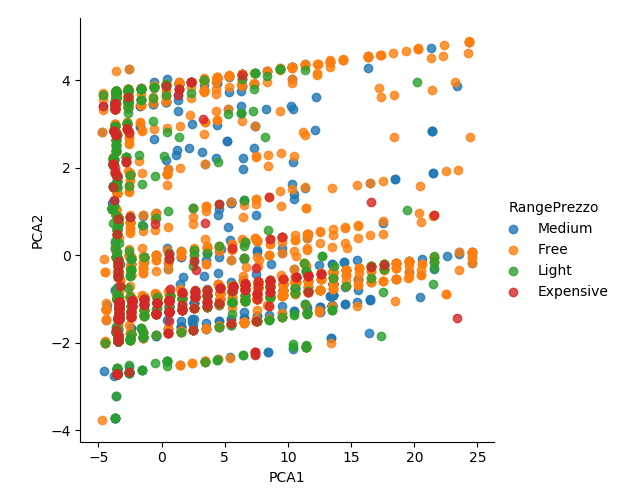

In [173]:
alfonsino['PCA1'] = X_2D[:, 0]
alfonsino['PCA2'] = X_2D[:, 1]
sns.lmplot("PCA1", "PCA2", hue='RangePrezzo', data=alfonsino, fit_reg=False);

In [174]:
model.explained_variance_ratio_

array([0.79985325, 0.10124896])

In [39]:
alfonsino2 = copy.deepcopy(one_hot_data)

In [40]:
conditions2 = [
    
    (alfonsino2["price"]<= 0.99),
    ((alfonsino2['price'] >= 1.0) & (alfonsino2['price'] <= 4.99)),
    (alfonsino2['price'] >= 5.0),
     ]
choices2 = ['Free or Light', 'Medium', "Expensive"]

alfonsino2['RangePrezzo'] = np.select(conditions2, choices2, default=None)

In [41]:
# model = PCA(n_components=2)            # 2. Instantiate the model with hyperparameters
# model.fit(alfonsino2.drop(alfonsino2.columns[-1], axis=1))                      # 3. Fit to data. Notice y is not specified!
# X_2D = model.transform(alfonsino2.drop(alfonsino2.columns[-1], axis=1))   

In [42]:
# model.explained_variance_ratio_

In [43]:
# alfonsino2['PCA1'] = X_2D[:, 0]
# alfonsino2['PCA2'] = X_2D[:, 1]
# sns.lmplot("PCA1", "PCA2", hue='RangePrezzo', data=alfonsino2, fit_reg=False);

In [44]:
alfonsino3 = copy.deepcopy(one_hot_data)

In [45]:
conditions3 = [
    
    (alfonsino3["price"]<= 2.99),
    ((alfonsino3['price'] >= 3.0) & (alfonsino3['price'] <= 6.99)),
    (alfonsino3['price'] >= 7.0),
     ]
choices3 = ['Free or Light', 'Medium', "Expensive"]

alfonsino3['RangePrezzo'] = np.select(conditions3, choices3, default=None)

In [46]:
# model = PCA(n_components=2)            # 2. Instantiate the model with hyperparameters
# model.fit(alfonsino3.drop(alfonsino3.columns[-1], axis=1))                      # 3. Fit to data. Notice y is not specified!
# X_2D = model.transform(alfonsino3.drop(alfonsino3.columns[-1], axis=1))   

In [47]:
# alfonsino3['PCA1'] = X_2D[:, 0]
# alfonsino3['PCA2'] = X_2D[:, 1]
# sns.lmplot("PCA1", "PCA2", hue='RangePrezzo', data=alfonsino3, fit_reg=False);

In [177]:
alfonsino4.head()

,price,sup_devices.num,ipadSc_urls.num,lang.num,cont_rating_12+,cont_rating_17+,cont_rating_4+,cont_rating_9+,prime_genre_Book,prime_genre_Business,...,prime_genre_News,prime_genre_Photo and Video,prime_genre_Productivity,prime_genre_Reference,prime_genre_Shopping,prime_genre_Social Networking,prime_genre_Sports,prime_genre_Travel,prime_genre_Utilities,prime_genre_Weather
0,3.99,38,5,10,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.00,37,5,23,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0.00,37,5,3,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,0.99,47,5,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0.00,37,0,19,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [178]:
alfonsino4=copy.deepcopy(one_hot_data)
choices1mod=[0,1,2,3]
alfonsino4['RangePrezzo'] = np.select(conditions1, choices1mod, default=None)
model = PCA(n_components=3)            # 2. Instantiate the model with hyperparameters
model.fit(alfonsino4.drop(alfonsino4.columns[[0,-1]], axis=1))                      # 3. Fit to data. Notice y is not specified!
X_2D = model.transform(alfonsino4.drop(alfonsino4.columns[[0,-1]], axis=1))   

In [179]:
model.explained_variance_ratio_

array([0.79985325, 0.10124896, 0.06985003])

In [145]:
choices1mod=[0,1,2,3]
alfonsino4['RangePrezzo'] = np.select(conditions1, choices1mod, default=None)

In [123]:
# alfonsino4.info()

<IPython.core.display.Javascript object>


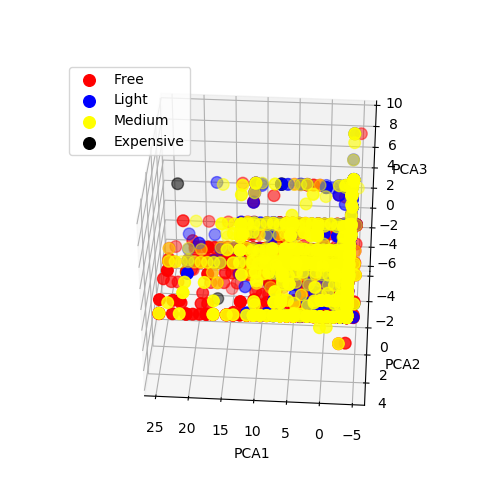

In [180]:
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib notebook

fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(111, projection='3d')

colors=["red", "blue", "yellow", "black"]

for i in choices1mod:
    ax.scatter(X_2D[alfonsino4["RangePrezzo"]==i,0], 
               X_2D[alfonsino4["RangePrezzo"]==i,1], 
               X_2D[alfonsino4["RangePrezzo"]==i,2], c=colors[i], s=70, label=choices1[i])

ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')

plt.legend()

plt.show()


In [100]:
alfonsino5=copy.deepcopy(one_hot_data)

conditions = [
    (df_nocat_noout['user_rating_ver'] > 3.5),
    ((df_nocat_noout['user_rating_ver'] > 2.5) & (df_nocat_noout['user_rating_ver'] <= 3.5)),
    (df_nocat_noout['user_rating_ver'] < 3.0)]
choices = ['Good', 'Okish', 'Bad']

alfonsino5['Grades'] = np.select(conditions, choices, default=None)

model = PCA(n_components=3)            # 2. Instantiate the model with hyperparameters
model.fit(alfonsino5.drop(alfonsino5.columns[-1], axis=1))                      # 3. Fit to data. Notice y is not specified!
X_2D = model.transform(alfonsino5.drop(alfonsino5.columns[-1], axis=1))   

In [101]:
model.explained_variance_ratio_

array([0.71087753, 0.1155575 , 0.08583588])

In [102]:
choices1mod2=[2,1,0]
alfonsino5['Grades'] = np.select(conditions, choices1mod2, default=None)

In [56]:
# alfonsino5.head()

<IPython.core.display.Javascript object>


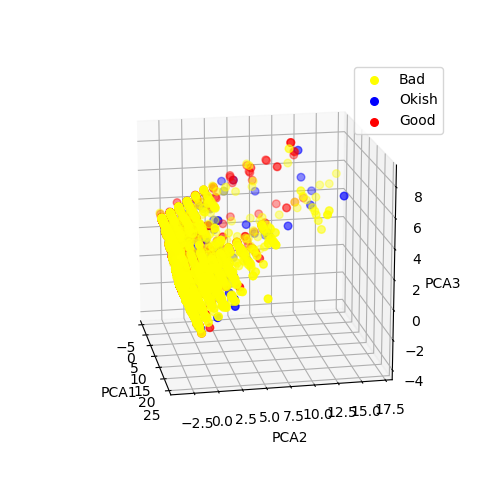

In [103]:
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(111, projection='3d')

colors=["red", "blue", "yellow", "black"]

for i in choices1mod2:
    ax.scatter(X_2D[alfonsino5["Grades"]==i,0], 
               X_2D[alfonsino5["Grades"]==i,1], 
               X_2D[alfonsino5["Grades"]==i,2], c=colors[i], s=30, label=choices[i])

ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')

plt.legend()

plt.show()

In [104]:
alfonsino6=copy.deepcopy(one_hot_data)

conditions6 = [
    
    (df_nocat_noout["ipadSc_urls.num"] == 0),
     ((df_nocat_noout["ipadSc_urls.num"] >= 1) & (df_nocat_noout["ipadSc_urls.num"]<=4)),
    (df_nocat_noout['ipadSc_urls.num'] ==5)]
choices6 = [0, 3, 5]

alfonsino6['Ipad_rate'] = np.select(conditions6, choices6, default=None)

model = PCA(n_components=3)            # 2. Instantiate the model with hyperparameters
model.fit(alfonsino6.drop(alfonsino6.columns[-1], axis=1))                      # 3. Fit to data. Notice y is not specified!
X_2D = model.transform(alfonsino6.drop(alfonsino6.columns[-1], axis=1))   

In [105]:
# alfonsino6.head()

In [60]:
# alfonsino6.groupby('Ipad_rate').count()

<IPython.core.display.Javascript object>


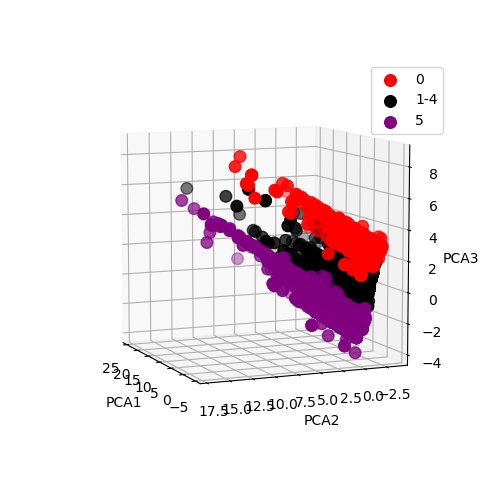

In [106]:
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(111, projection='3d')

colors=["red", "blue", "yellow", "black", "green","purple"]

labels=["0","a","a","1-4","a", "5"]

for i in choices6:
    ax.scatter(X_2D[alfonsino6["Ipad_rate"]==i,0], 
               X_2D[alfonsino6["Ipad_rate"]==i,1], 
               X_2D[alfonsino6["Ipad_rate"]==i,2], c=colors[i], s=70, label=labels[i])

ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')

plt.legend()

plt.show()

#nooooooo

## Putting back size

In [62]:
# df = pd.read_csv('C:/Users/Guglielmo/Desktop/AppleStore.csv', sep=',', header=0, index_col=0)
# df.head()

In [63]:
alfonsino7=copy.deepcopy(one_hot_data)

In [64]:
# alfonsino7.head()

In [65]:
# df_nocat_noout.head()

In [66]:
sandro=pd.concat([df_nocat_noout, df_cont, df_gen], axis = 1)

In [67]:
# sandro.head()

In [68]:
sandro2 = pd.get_dummies(sandro, columns=['cont_rating','prime_genre'])

In [69]:
sandro2.head()

,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,sup_devices.num,ipadSc_urls.num,lang.num,cont_rating_12+,cont_rating_17+,...,prime_genre_News,prime_genre_Photo & Video,prime_genre_Productivity,prime_genre_Reference,prime_genre_Shopping,prime_genre_Social Networking,prime_genre_Sports,prime_genre_Travel,prime_genre_Utilities,prime_genre_Weather
0,3.99,21292,26,4.0,4.5,38,5,10,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.00,161065,26,4.0,3.5,37,5,23,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0.00,188583,2822,3.5,4.5,37,5,3,0,0,...,0,0,0,0,0,0,0,0,0,1
5,0.99,8253,5516,4.0,4.0,47,5,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0.00,119487,879,4.0,4.5,37,0,19,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
sandro3=sandro2.drop(sandro2.columns[[2,4]], axis=1) #levo ver

In [71]:
sandro4=sandro2.drop(sandro2.columns[[1,3]], axis=1) #levo tot

In [72]:
model = PCA(n_components=3)            # 2. Instantiate the model with hyperparameters
model.fit(sandro3)                      # 3. Fit to data. Notice y is not specified!
X_2D = model.transform(sandro3)   

In [73]:
model.explained_variance_ratio_

array([9.99999905e-01, 6.43588150e-08, 1.07829899e-08])

In [74]:
giochi1=one_hot_data[one_hot_data["prime_genre_Games"]==1].reset_index(drop=True)

In [75]:
giochi1=giochi1.drop(giochi1.loc[:,"prime_genre_Games"])

In [107]:
# giochi1.head()

In [77]:
model = PCA(n_components=3)            # 2. Instantiate the model with hyperparameters
model.fit(giochi1)                      # 3. Fit to data. Notice y is not specified!
X_2D = model.transform(giochi1)   

In [78]:
model.explained_variance_ratio_

array([0.70175348, 0.13115375, 0.09108297])

In [116]:
list_genres=list(set(df["prime_genre"]))

In [117]:
list_genres_mod=copy.deepcopy(list_genres)

In [ ]:
# list_genres_mod

In [119]:
list_genres_mod[4]=list_genres_mod[4].replace("&","and")
list_genres_mod[19]=list_genres_mod[19].replace('&','and')
list_genres_mod[-2]=list_genres_mod[-2].replace('&','and')

In [147]:
# list_genres_mod

In [111]:
conditions_altro = [
    (df_nocat_noout['user_rating_ver'] > 3.5),
    ((df_nocat_noout['user_rating_ver'] > 2.0) & (df_nocat_noout['user_rating_ver'] <= 3.5)),
    (df_nocat_noout['user_rating_ver'] <= 2.0)]
choices = ['Good', 'Okish', 'Bad']

In [122]:
# for item in list_genres_mod:
    
#     procopio=copy.deepcopy(one_hot_data)
#     procopio['Grades'] = np.select(conditions_altro, choices, default=None)
    
#     giochi1=procopio[procopio["prime_genre_{0}".format(item)]==1].reset_index(drop=True)
#     giochi1=giochi1.drop(giochi1.loc[:,"prime_genre_{0}".format(item)])
    
#     model = PCA(n_components=3)            
#     model.fit(giochi1.drop(giochi1.columns[-1],axis=1))                      
#     X_2D = model.transform(giochi1.drop(giochi1.columns[-1],axis=1))
    
#     print(item, model.explained_variance_ratio_)
    
    
    
#     giochi1['PCA1'] = X_2D[:, 0]
#     giochi1['PCA2'] = X_2D[:, 1]
#     sns.lmplot("PCA1", "PCA2", hue='Grades', data=giochi1, fit_reg=False)
#     plt.show()
    

In [125]:
conditions1 = [
    (alfonsino['price'] == 0.00),
    (alfonsino["price"]== 0.99),
    ((alfonsino['price'] >= 1.0) & (alfonsino['price'] <= 4.99)),
    (alfonsino['price'] >= 5.0),
     ]
choices1 = ['Free', 'Light', 'Medium', "Expensive"]

alfonsino['RangePrezzo'] = np.select(conditions1, choices1, default=None)

In [128]:
# for item in list_genres_mod:
    
#     procopio1=copy.deepcopy(one_hot_data)
#     procopio1['RangePrezzo'] = np.select(conditions1, choices1, default=None)
    
#     giochi2=procopio1[procopio1["prime_genre_{0}".format(item)]==1].reset_index(drop=True)
#     giochi2=giochi2.drop(giochi2.loc[:,"prime_genre_{0}".format(item)])
    
#     model = PCA(n_components=3)            
#     model.fit(giochi2.drop(giochi2.columns[-1],axis=1))                      
#     X_2D = model.transform(giochi2.drop(giochi2.columns[-1],axis=1))
    
#     print(item, model.explained_variance_ratio_)
    
    
    
#     giochi2['PCA1'] = X_2D[:, 0]
#     giochi2['PCA2'] = X_2D[:, 1]
#     sns.lmplot("PCA1", "PCA2", hue='RangePrezzo', data=giochi2, fit_reg=False)
#     plt.show()

Let's try using Gini criterion.

In [ ]:
rnd_state = 666
clf = tree.DecisionTreeClassifier(criterion='gini', random_state = rnd_state)
clf.fit(X_train, y_train)

In [ ]:
y_predicted_train = clf.predict(X_train)
accuracy_train = np.mean(y_train == y_predicted_train)*100
print("The accuracy on training set is {0:.1f}%".format(accuracy_train))

In [ ]:
y_predicted_test = clf.predict(X_test)
accuracy_test = np.mean(y_test == y_predicted_test)*100
print("The accuracy on test set is {0:.1f}%".format(accuracy_test))

### Elbow Method

In [ ]:
avg_scores = []

parameter_values = np.arange(1,15)
for hp in parameter_values:
    estimator = tree.DecisionTreeClassifier(criterion="entropy"
#                                            , min_impurity_decrease = hp
                                            , max_depth = hp,
                                            random_state=rnd_state
                                           )
    estimator.fit(X_train, y_train)
    y_predicted = estimator.predict(X_test)
    score = np.mean(y_test == y_predicted) * 100 # compute the matches between prediction and true classes
    avg_scores.append(score)


In [ ]:
# plt.figure(figsize=(32,20))
# plt.plot(parameter_values, avg_scores, '-o', linewidth=5, markersize=24)
# plt.xlabel('max_depth')
# plt.ylabel('accuracy')

In [ ]:
top_accuracy_holdout = avg_scores[np.argmax(avg_scores)]
top_hp_holdout = parameter_values[np.argmax(avg_scores)]
print("The top accuracy is {0:.1f}%".format(top_accuracy_holdout))
print("Obtained with max_depth = {0:.1f}".format(top_hp_holdout))

### Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score
avg_scores = []
parameter_values = np.arange(1, 10)
for hp in parameter_values:
    estimator = tree.DecisionTreeClassifier(criterion="entropy"
#                                            , min_impurity_decrease = hp
                                            , max_depth = hp,
                                            random_state=rnd_state
                                            )
    scores = cross_val_score(estimator, one_hot_data, df_grade, scoring='accuracy', cv=10)
    avg_scores.append(np.mean(scores))
print(avg_scores)

In [ ]:
# plt.figure(figsize=(32,20))
# plt.plot(parameter_values, avg_scores, '-o', linewidth=5, markersize=24)
# plt.show()

In [ ]:
top_accuracy_cv = avg_scores[np.argmax(avg_scores)]*100
top_hp_cv = parameter_values[np.argmax(avg_scores)]
print("The top accuracy forecast with cross validation is {0:.1f}%".format(top_accuracy_cv))
print("Obtained with max_depth = {0:.1f}".format(top_hp_cv))

In [ ]:
bubazz=one_hot_data.iloc[:,:].values

In [ ]:
# one_hot_data.head()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(bubazz)

In [ ]:
# X_scaled

In [ ]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3, 
            init='random', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=rnd_state)

y_km = km.fit_predict(X_scaled)

In [ ]:
km.inertia_

In [ ]:
km1 = KMeans(n_clusters=3, 
            init='k-means++', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=rnd_state)

y_km1 = km1.fit_predict(X_scaled)

In [ ]:
km1.inertia_

In [ ]:
print(y_km)

In [ ]:
import copy
gigi = copy.deepcopy(one_hot_data)


In [ ]:
gigi["cluster"]=y_km

In [ ]:
gigi1=gigi.drop(gigi.columns[4:-1], axis=1)

In [ ]:
# gigi.head()

In [ ]:
# gigi1.head()

In [ ]:
enzo = copy.deepcopy(df_nocat_noout)

In [ ]:
enzo["cluster"]=y_km
enzo.head()

In [ ]:
enzo2=enzo.drop(enzo.columns[1:3], axis=1)

In [ ]:
enzo3=enzo.drop(enzo.columns[5:-1], axis=1)

In [ ]:
# pd.plotting.parallel_coordinates(gigi1, 'cluster', color=('red', 'yellow', 'blue') )
# plt.show()

In [ ]:
# pd.plotting.parallel_coordinates(enzo, 'cluster', color=('red', 'yellow', 'blue') )
# plt.show()

In [ ]:
# pd.plotting.parallel_coordinates(enzo2, 'cluster', color=('red', 'yellow', 'blue') )
# plt.show()

In [ ]:
# pd.plotting.parallel_coordinates(enzo3, 'cluster', color=('red', 'yellow', 'blue') )
# plt.show()

In [ ]:
marco=df_nocat_noout.iloc[:,:].values
scaler = MinMaxScaler()
X_scaled2 = scaler.fit_transform(marco)

In [ ]:
X_scaled2_df=pd.DataFrame(X_scaled2)

In [ ]:
X_scaled2_df.columns=df_nocat_noout.iloc[:,:].columns.values

In [ ]:
X_scaled2_df["cluster"]=y_km
#X_scaled2_df["cluster_kmeans"]=y_km1
# X_scaled2_df.head()

In [ ]:
# pd.plotting.parallel_coordinates(X_scaled2_df, 'cluster', color=('red', 'yellow', 'blue') )
# plt.show()

In [ ]:
orso1= X_scaled2_df.drop(X_scaled2_df.columns[0:3], axis=1)
orso1=orso1.drop(orso1.columns[2:5], axis=1)
# pd.plotting.parallel_coordinates(orso1, 'cluster', color=('red', 'yellow', 'blue') )
# plt.show()

In [ ]:
orso2= X_scaled2_df.drop(X_scaled2_df.columns[3:8], axis=1)
# pd.plotting.parallel_coordinates(orso2, 'cluster', color=('red', 'yellow', 'blue') )
# plt.show()

In [ ]:
# labels = np.unique(y_km)
# colors = ['brown', 'orange', 'olive', 'green', 'cyan', 'blue', 'purple', 'pink']
# for i in range(len(labels)):
#     plt.scatter(X_scaled[y_km==labels[i],0], 
#                 X_scaled[y_km==labels[i],3], 
#                 s=10, 
#                 c=colors[i], 
#                 marker='s', 
#                 label='cluster'+str(labels[i]))
# plt.scatter(km.cluster_centers_[:,0], 
#             km.cluster_centers_[:,3], 
#             s=50, 
#             marker='*', 
#             c='red', 
#             label='centroids')
# plt.legend()
# plt.grid()
# plt.show()   

In [ ]:
for i in range(0,3):
    print(one_hot_data[y_km==i].shape)


In [ ]:
# one_hot_data[y_km==0].describe()

In [ ]:
# one_hot_data[y_km==1].describe()

In [ ]:
# one_hot_data[y_km==2].describe()

In [ ]:
list_genres=list(set(df["prime_genre"]))

In [ ]:
# list_genres

In [ ]:
div_genre={}
for item in list_genres:
    div_genre["{0}".format(item)]=df[df["prime_genre"]==item]

In [ ]:
# div_genre["Book"].head(2)

In [ ]:
# div_genre["Book"]=div_genre["Book"].drop(div_genre["Book"].columns[5:7], axis=1)
# div_genre["Book"].head(2)

In [ ]:
# (df["cont_rating"]).value_counts()

In [ ]:
for item in list_genres:
    div_genre["{0}".format(item)]=div_genre["{0}".format(item)].drop(div_genre["{0}".format(item)].columns[5:7], axis=1)

In [ ]:
# div_genre["Games"].head(2)

In [ ]:
km_games = KMeans(n_clusters=3, 
            init='random', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=rnd_state)

y_km_games = km_games.fit_predict(div_genre["Games"].iloc[:,:].values)


In [ ]:
km_games.inertia_

In [ ]:
div_genre["Games"]["cluster"]=y_km_games

In [ ]:
# pd.plotting.parallel_coordinates(div_genre["Games"], 'cluster', color=('red', 'yellow', 'blue') )
# plt.show()

In [ ]:
div_genre["Games"]=div_genre["Games"].drop(div_genre["Games"].columns[-1], axis=1)

km_games_scal = KMeans(n_clusters=3, 
            init='random', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=rnd_state)

games_scaled = scaler.fit_transform(div_genre["Games"].iloc[:,:].values)

y_km_games_scal = km_games_scal.fit_predict(games_scaled)

In [ ]:
km_games_scal.inertia_

In [ ]:
# games_scaled

In [ ]:
games_scaled=pd.DataFrame(games_scaled)
games_scaled.columns=div_genre["Games"].columns.values
games_scaled["cluster"]=y_km_games_scal

In [ ]:
# pd.plotting.parallel_coordinates(games_scaled, 'cluster', color=('red', 'yellow', 'blue') )
# plt.show()

In [ ]:
games_scaled1=games_scaled.drop(games_scaled.columns[3:5], axis=1)
# pd.plotting.parallel_coordinates(games_scaled1, 'cluster', color=('red', 'yellow', 'blue') )
# plt.show()

In [ ]:
# div_genre["Games"].describe()

In [ ]:
low = .01
high = .99
quant_df = div_genre["Games"].quantile([low, high])

In [ ]:
divgames=copy.deepcopy(div_genre["Games"])

In [ ]:
divgames=divgames.drop(divgames.columns[[0,6,7]], axis=1) #drop some columns

In [ ]:
div_genre_games_noout = divgames.apply(lambda x: x[(x>quant_df.loc[low,x.name]) & 
                                    (x < quant_df.loc[high,x.name])], axis=0)

In [ ]:
# div_genre["Games"].columns[[0,6,7]][0]

In [ ]:
# div_genre["Games"].iloc[:,[0,6,7]].head(2)

In [ ]:
# div_genre_games_noout.describe()

In [ ]:
div_genre_games_noout= pd.concat([div_genre["Games"].iloc[:,[0,6,7]], div_genre_games_noout], axis=1)

In [ ]:
div_genre_games_noout.dropna(inplace=True)

In [ ]:
#div_genre["Games"]=div_genre["Games"].drop(div_genre["Games"].columns[-1], axis=1)

km_games_scal_noout = KMeans(n_clusters=3, 
            init='random', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=rnd_state)

games_scaled_noout = scaler.fit_transform(div_genre_games_noout.iloc[:,:].values)

y_km_games_scal_noout = km_games_scal_noout.fit_predict(games_scaled_noout)

In [ ]:
games_scaled_noout=pd.DataFrame(games_scaled_noout)
games_scaled_noout.columns=div_genre["Games"].columns.values
games_scaled_noout["cluster"]=y_km_games_scal_noout

In [ ]:
# plt.figure(figsize=(20,10))
# pd.plotting.parallel_coordinates(games_scaled_noout, 'cluster', color=('red', 'yellow', 'blue') )
# plt.show()

In [ ]:
# plt.figure(figsize=(20,10))
# pd.plotting.parallel_coordinates(games_scaled_noout[games_scaled_noout["cluster"]!=0], 
#                                  'cluster', 
#                                  color=('yellow', 'blue') )

# plt.show()

In [ ]:
# games_scaled_noout.describe()

In [ ]:
games_scaled_noout1=games_scaled_noout.drop(games_scaled.columns[[0,3,4]], axis=1)
# pd.plotting.parallel_coordinates(games_scaled_noout1, 'cluster', color=('red', 'yellow', 'blue') )
# plt.show()

In [ ]:
games_scaled_noout2=games_scaled_noout.drop(games_scaled.columns[[0,5,6,7]], axis=1)
# pd.plotting.parallel_coordinates(games_scaled_noout2, 'cluster', color=('red', 'yellow', 'blue') )
# plt.show()

In [ ]:
for i in range(0,3):
    print(games_scaled_noout[games_scaled_noout["cluster"]==i].shape)

In [ ]:
#with outliers, scaled

# for item in list_genres:
#     km_gg = KMeans(n_clusters=3, 
#             init='random', 
#             n_init=10, 
#             max_iter=300,
#             tol=1e-04,
#             random_state=rnd_state)

#     gianni_scaled = scaler.fit_transform(div_genre["{0}".format(item)].iloc[:,:].values)

#     y_km_gg = km_gg.fit_predict(gianni_scaled)
    
#     gianni_scaled=pd.DataFrame(gianni_scaled)
#     gianni_scaled.columns=div_genre["{0}".format(item)].columns.values
#     gianni_scaled["cluster"]=y_km_gg
    
#     pd.plotting.parallel_coordinates(gianni_scaled, 'cluster', color=('red', 'yellow', 'blue') )
#     plt.xlabel("{0}".format(item))
#     plt.show()
#     print(div_genre["{0}".format(item)].shape)


In [ ]:
# for item in list_genres:
#     km_gg = KMeans(n_clusters=3, 
#             init='random', 
#             n_init=10, 
#             max_iter=300,
#             tol=1e-04,
#             random_state=rnd_state)

#     gianni_scaled = scaler.fit_transform(div_genre["{0}".format(item)].iloc[:,:].values)

#     y_km_gg = km_gg.fit_predict(gianni_scaled)
#     cluster_labels = np.unique(y_km_gg)
#     n_clusters = cluster_labels.shape[0] 

#     silhouette_vals = silhouette_samples(gianni_scaled, y_km_gg, metric='euclidean')
#     y_ax_lower, y_ax_upper = 0, 0
#     yticks = []
#     for i, c in enumerate(cluster_labels): 
#         c_silhouette_vals = silhouette_vals[y_km_gg==c] 
#         c_silhouette_vals.sort() 
#         y_ax_upper += len(c_silhouette_vals)
#         color = cm.jet(i / n_clusters)
#         plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
#             edgecolor='none', color=color)
#         yticks.append((y_ax_lower + y_ax_upper) / 2)
#         y_ax_lower += len(c_silhouette_vals)
    
#     silhouette_avg = np.mean(silhouette_vals)
#     plt.axvline(silhouette_avg, color="red", linestyle="--") 

#     plt.yticks(yticks, cluster_labels + 1)
#     plt.ylabel('Cluster')
#     plt.xlabel('Silhouette coefficient '+"{0}".format(item))
#     plt.show()
    

In [ ]:
# low = .01
# high = .99
# list_genres.remove("Catalogs")
# for item in list_genres:
    
#     quant_df = div_genre["{0}".format(item)].quantile([low, high])
#     divgames=copy.deepcopy(div_genre["{0}".format(item)])
#     divgames=divgames.drop(divgames.columns[[0,6,7]], axis=1) #drop some columns
#     div_games_noout = divgames.apply(lambda x: x[(x>quant_df.loc[low,x.name]) & 
#                                     (x < quant_df.loc[high,x.name])], axis=0)
#     div_games_noout= pd.concat([div_genre["{0}".format(item)].iloc[:,[0,6,7]], div_games_noout], axis=1)
#     div_games_noout.dropna(inplace=True)
    
    
#     km_gg = KMeans(n_clusters=3, 
#             init='random', 
#             n_init=10, 
#             max_iter=300,
#             tol=1e-04,
#             random_state=rnd_state)

#     gianni_scaled = scaler.fit_transform(div_games_noout)

#     y_km_gg = km_gg.fit_predict(gianni_scaled)
    
#     gianni_scaled=pd.DataFrame(gianni_scaled)
#     gianni_scaled.columns=div_genre["{0}".format(item)].columns.values
#     gianni_scaled["cluster"]=y_km_gg
    
#     #plt.figure(figsize=(10,10))
#     pd.plotting.parallel_coordinates(gianni_scaled, 'cluster', color=('red', 'yellow', 'blue') )
#     plt.xlabel("{0}".format(item))
#     plt.show()
#     print(div_games_noout.shape)

In [ ]:
# for item in list_genres:
    
#     quant_df = div_genre["{0}".format(item)].quantile([low, high])
#     divgames=copy.deepcopy(div_genre["{0}".format(item)])
#     divgames=divgames.drop(divgames.columns[[0,6,7]], axis=1) #drop some columns
#     div_games_noout = divgames.apply(lambda x: x[(x>quant_df.loc[low,x.name]) & 
#                                     (x < quant_df.loc[high,x.name])], axis=0)
#     div_games_noout= pd.concat([div_genre["{0}".format(item)].iloc[:,[0,6,7]], div_games_noout], axis=1)
#     div_games_noout.dropna(inplace=True)
    
#     km_gg = KMeans(n_clusters=3, 
#             init='random', 
#             n_init=10, 
#             max_iter=300,
#             tol=1e-04,
#             random_state=rnd_state)

#     gianni_scaled = scaler.fit_transform(div_games_noout)

#     y_km_gg = km_gg.fit_predict(gianni_scaled)
#     cluster_labels = np.unique(y_km_gg)
#     n_clusters = cluster_labels.shape[0] 

#     silhouette_vals = silhouette_samples(gianni_scaled, y_km_gg, metric='euclidean')
#     y_ax_lower, y_ax_upper = 0, 0
#     yticks = []
#     for i, c in enumerate(cluster_labels): 
#         c_silhouette_vals = silhouette_vals[y_km_gg==c] 
#         c_silhouette_vals.sort() 
#         y_ax_upper += len(c_silhouette_vals)
#         color = cm.jet(i / n_clusters)
#         plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
#             edgecolor='none', color=color)
#         yticks.append((y_ax_lower + y_ax_upper) / 2)
#         y_ax_lower += len(c_silhouette_vals)
    
#     silhouette_avg = np.mean(silhouette_vals)
#     plt.axvline(silhouette_avg, color="red", linestyle="--") 

#     plt.yticks(yticks, cluster_labels + 1)
#     plt.ylabel('Cluster')
#     plt.xlabel('Silhouette coefficient '+"{0}".format(item))
#     plt.show()

In [ ]:
#fill nan with mean

# low = .01
# high = .99
# #list_genres.remove("Catalogs")
# for item in list_genres:
    
#     quant_df = div_genre["{0}".format(item)].quantile([low, high])
#     divgames=copy.deepcopy(div_genre["{0}".format(item)])
#     divgames=divgames.drop(divgames.columns[[0,6,7]], axis=1) #drop some columns
#     div_games_noout = divgames.apply(lambda x: x[(x>quant_df.loc[low,x.name]) & 
#                                     (x < quant_df.loc[high,x.name])], axis=0)
#     div_games_noout= pd.concat([div_genre["{0}".format(item)].iloc[:,[0,6,7]], div_games_noout], axis=1)
#     div_games_noout_fill= div_games_noout.fillna(div_games_noout.mean())
    
    
#     km_gg = KMeans(n_clusters=3, 
#             init='random', 
#             n_init=10, 
#             max_iter=300,
#             tol=1e-04,
#             random_state=rnd_state)

#     gianni_scaled = scaler.fit_transform(div_games_noout_fill)

#     y_km_gg = km_gg.fit_predict(gianni_scaled)
    
#     gianni_scaled=pd.DataFrame(gianni_scaled)
#     gianni_scaled.columns=div_genre["{0}".format(item)].columns.values
#     gianni_scaled["cluster"]=y_km_gg
    
#     #plt.figure(figsize=(10,10))
#     pd.plotting.parallel_coordinates(gianni_scaled, 'cluster', color=('red', 'yellow', 'blue') )
#     plt.xlabel("{0}".format(item))
#     plt.show()
#     print(div_games_noout.shape)

In [ ]:
# for item in list_genres:
    
#     quant_df = div_genre["{0}".format(item)].quantile([low, high])
#     divgames=copy.deepcopy(div_genre["{0}".format(item)])
#     divgames=divgames.drop(divgames.columns[[0,6,7]], axis=1) #drop some columns
#     div_games_noout = divgames.apply(lambda x: x[(x>quant_df.loc[low,x.name]) & 
#                                     (x < quant_df.loc[high,x.name])], axis=0)
#     div_games_noout= pd.concat([div_genre["{0}".format(item)].iloc[:,[0,6,7]], div_games_noout], axis=1)
#     div_games_noout_fill= div_games_noout.fillna(div_games_noout.mean())
    
#     km_gg = KMeans(n_clusters=3, 
#             init='random', 
#             n_init=10, 
#             max_iter=300,
#             tol=1e-04,
#             random_state=rnd_state)

#     gianni_scaled = scaler.fit_transform(div_games_noout_fill)

#     y_km_gg = km_gg.fit_predict(gianni_scaled)
#     cluster_labels = np.unique(y_km_gg)
#     n_clusters = cluster_labels.shape[0] 

#     silhouette_vals = silhouette_samples(gianni_scaled, y_km_gg, metric='euclidean')
#     y_ax_lower, y_ax_upper = 0, 0
#     yticks = []
#     for i, c in enumerate(cluster_labels): 
#         c_silhouette_vals = silhouette_vals[y_km_gg==c] 
#         c_silhouette_vals.sort() 
#         y_ax_upper += len(c_silhouette_vals)
#         color = cm.jet(i / n_clusters)
#         plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
#             edgecolor='none', color=color)
#         yticks.append((y_ax_lower + y_ax_upper) / 2)
#         y_ax_lower += len(c_silhouette_vals)
    
#     silhouette_avg = np.mean(silhouette_vals)
#     plt.axvline(silhouette_avg, color="red", linestyle="--") 

#     plt.yticks(yticks, cluster_labels + 1)
#     plt.ylabel('Cluster')
#     plt.xlabel('Silhouette coefficient '+"{0}".format(item))
#     plt.show()

In [ ]:
# df["lang.num"].value_counts()

In [ ]:
# df['prime_genre'].value_counts()

In [ ]:
# Visualizing 6-D mix data using scatter charts
# leveraging the concepts of hue, size, depth and shape
# from mpl_toolkits.mplot3d import Axes3D

# fig = plt.figure(figsize=(20, 20))
# t = fig.suptitle('PROVA1', fontsize=14)
# ax = fig.add_subplot(111, projection='3d')

# xs = list(df['price'])
# ys = list(df['rating_count_ver'])
# zs = list(df['user_rating_ver'])
# data_points = [(x, y, z) for x, y, z in zip(xs, ys, zs)]

# #ss = list(df['prime_genre'])
# #colors = ['red' if wt == 5 else "blue" if wt== 4 else "black" if wt== 0 else 'yellow' for wt in list(df['ipadSc_urls.num'])]
# markers = [',' if q < 16 else 'x' for q in list(df['lang.num'])]

# ss=list(df['ipadSc_urls.num']) #ss=[i*10 for i in list(df['ipadSc_urls.num'])]
# colors=['red' if wt == "Games" else "blue" if wt== "Entertainment" else "black" if wt== "Education" else 'yellow' if wt == "Photo & Video" else "brown" for wt in list(df['prime_genre'])]

# for data, color, size, mark in zip(data_points, colors, ss, markers):
#     x, y, z = data
#     ax.scatter(x, y, z, alpha=0.4, c=color, edgecolors='none', s=size, marker=mark)

# ax.set_xlabel('price')
# ax.set_ylabel('rating count ver')
# ax.set_zlabel('user rating ver')

In [ ]:
alfio=copy.deepcopy(df_nocat_noout)

In [ ]:
# alfio.head(2)

<IPython.core.display.Javascript object>


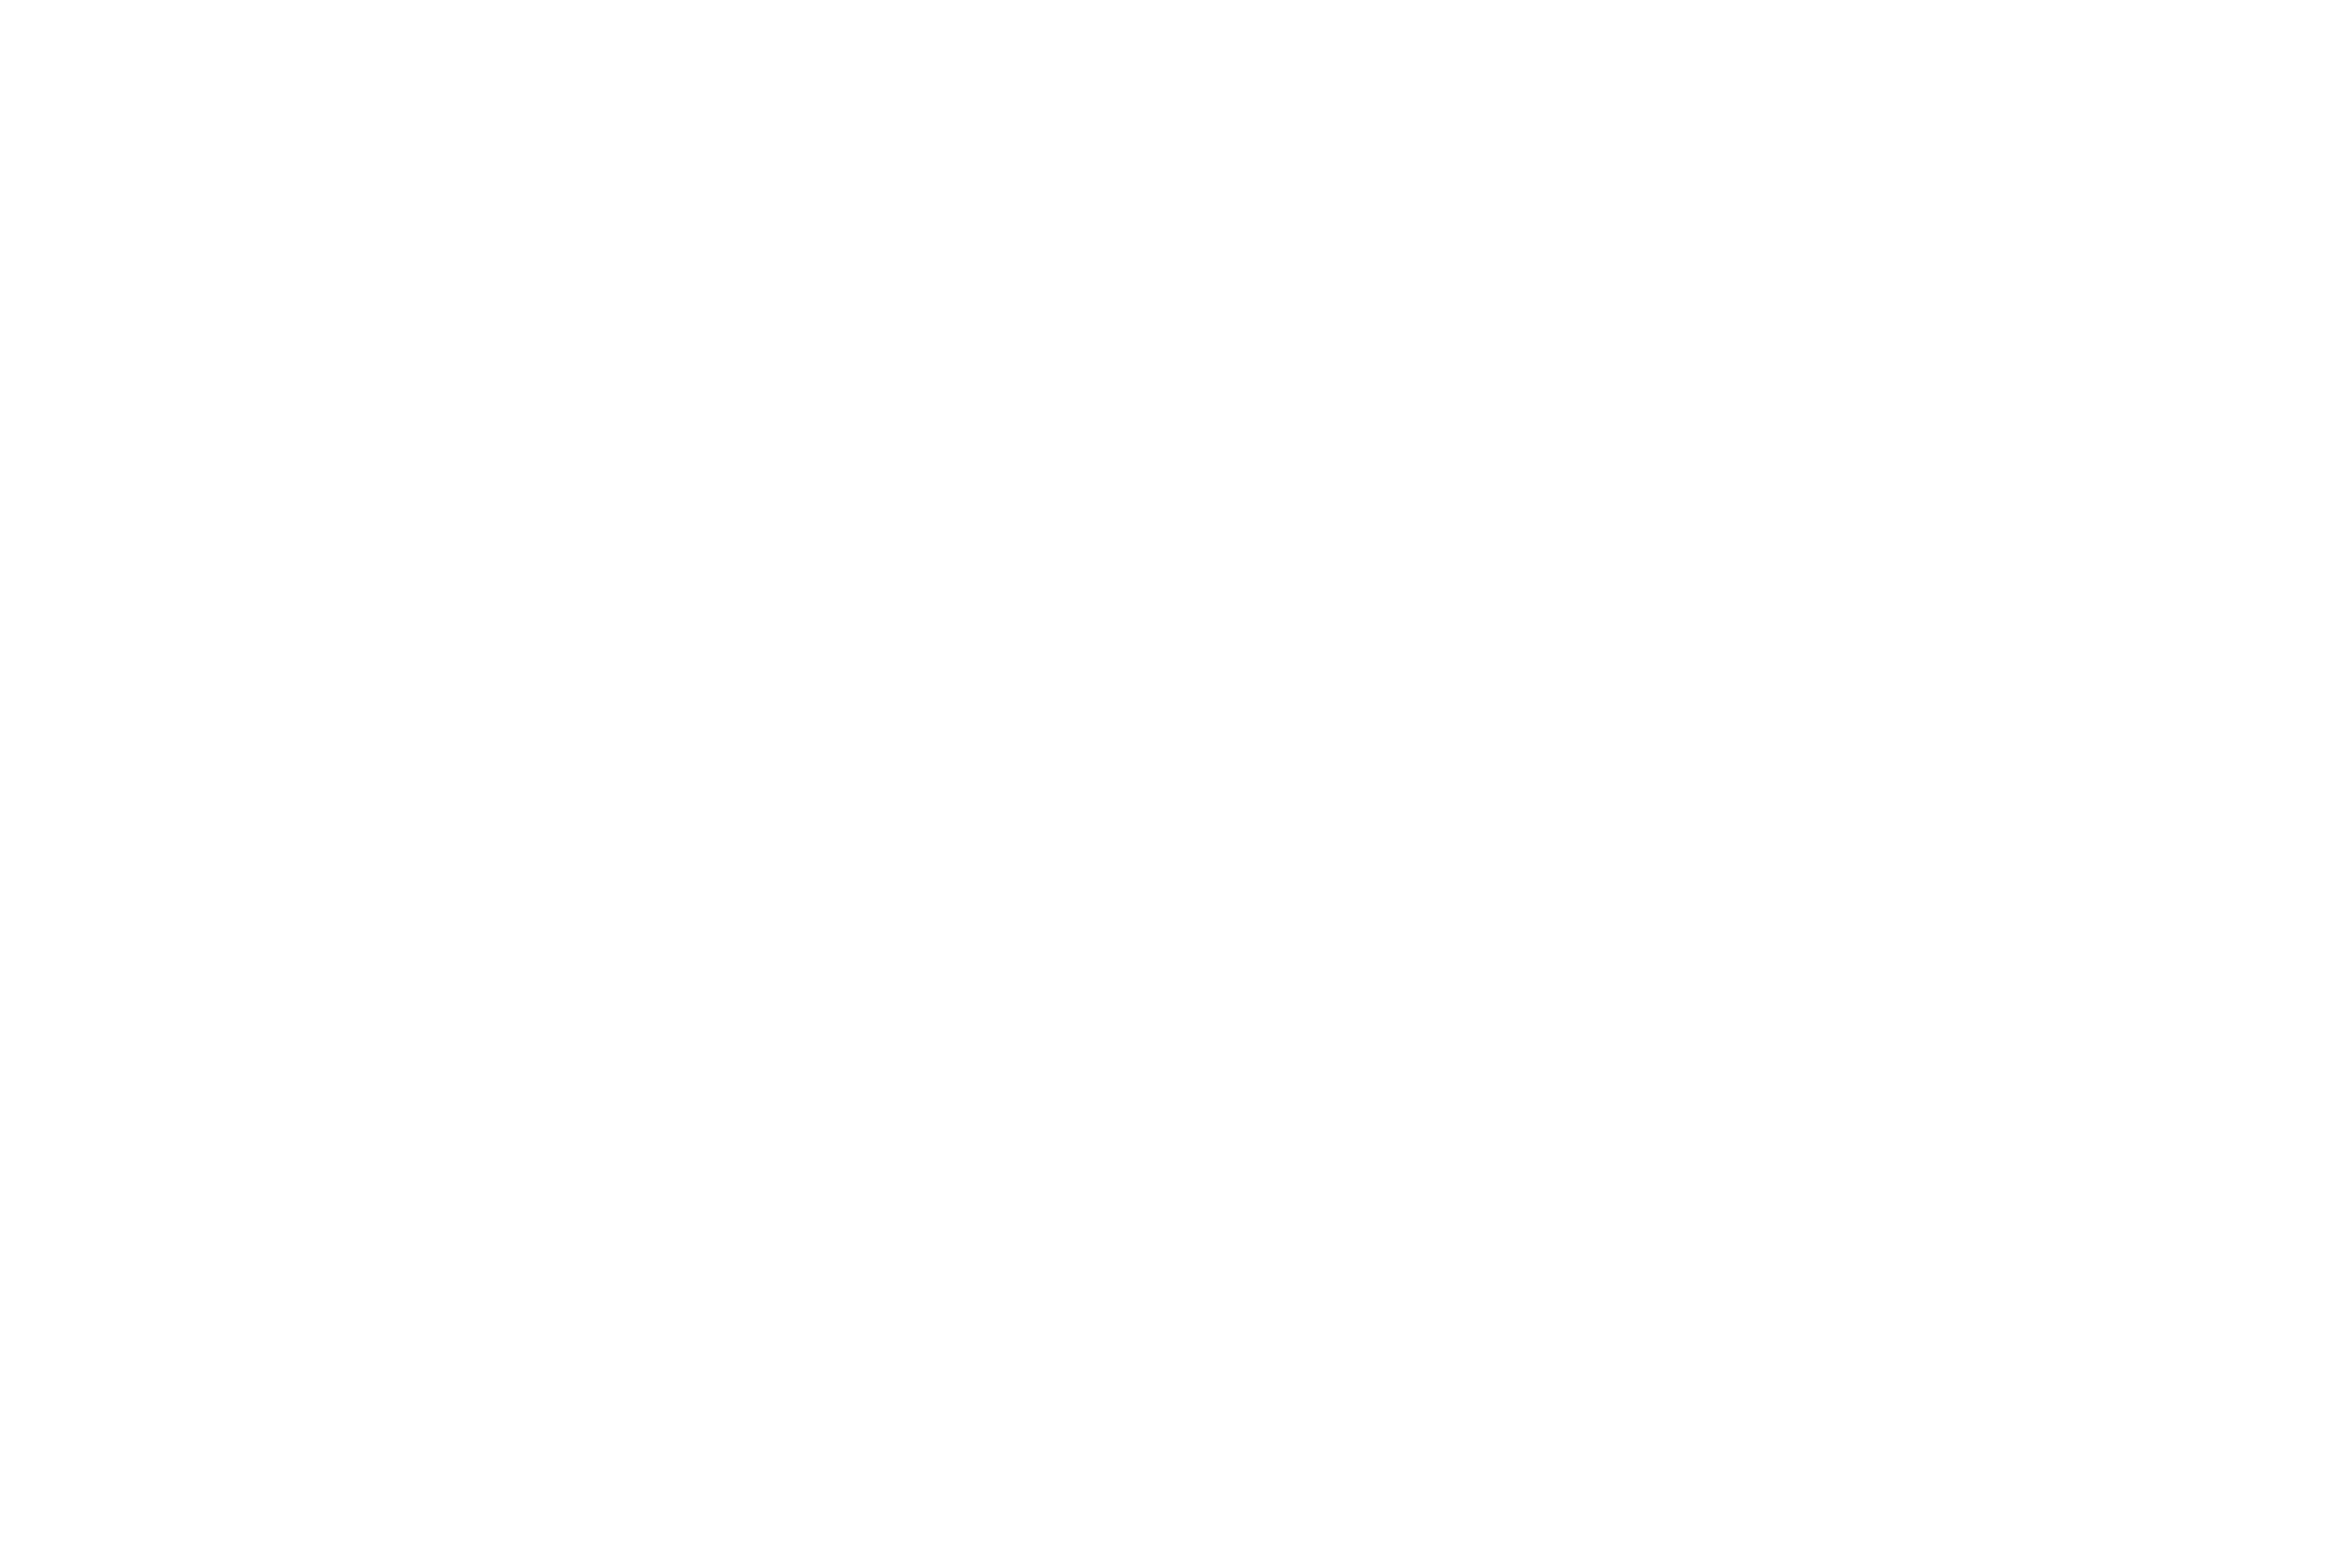

<IPython.core.display.Javascript object>


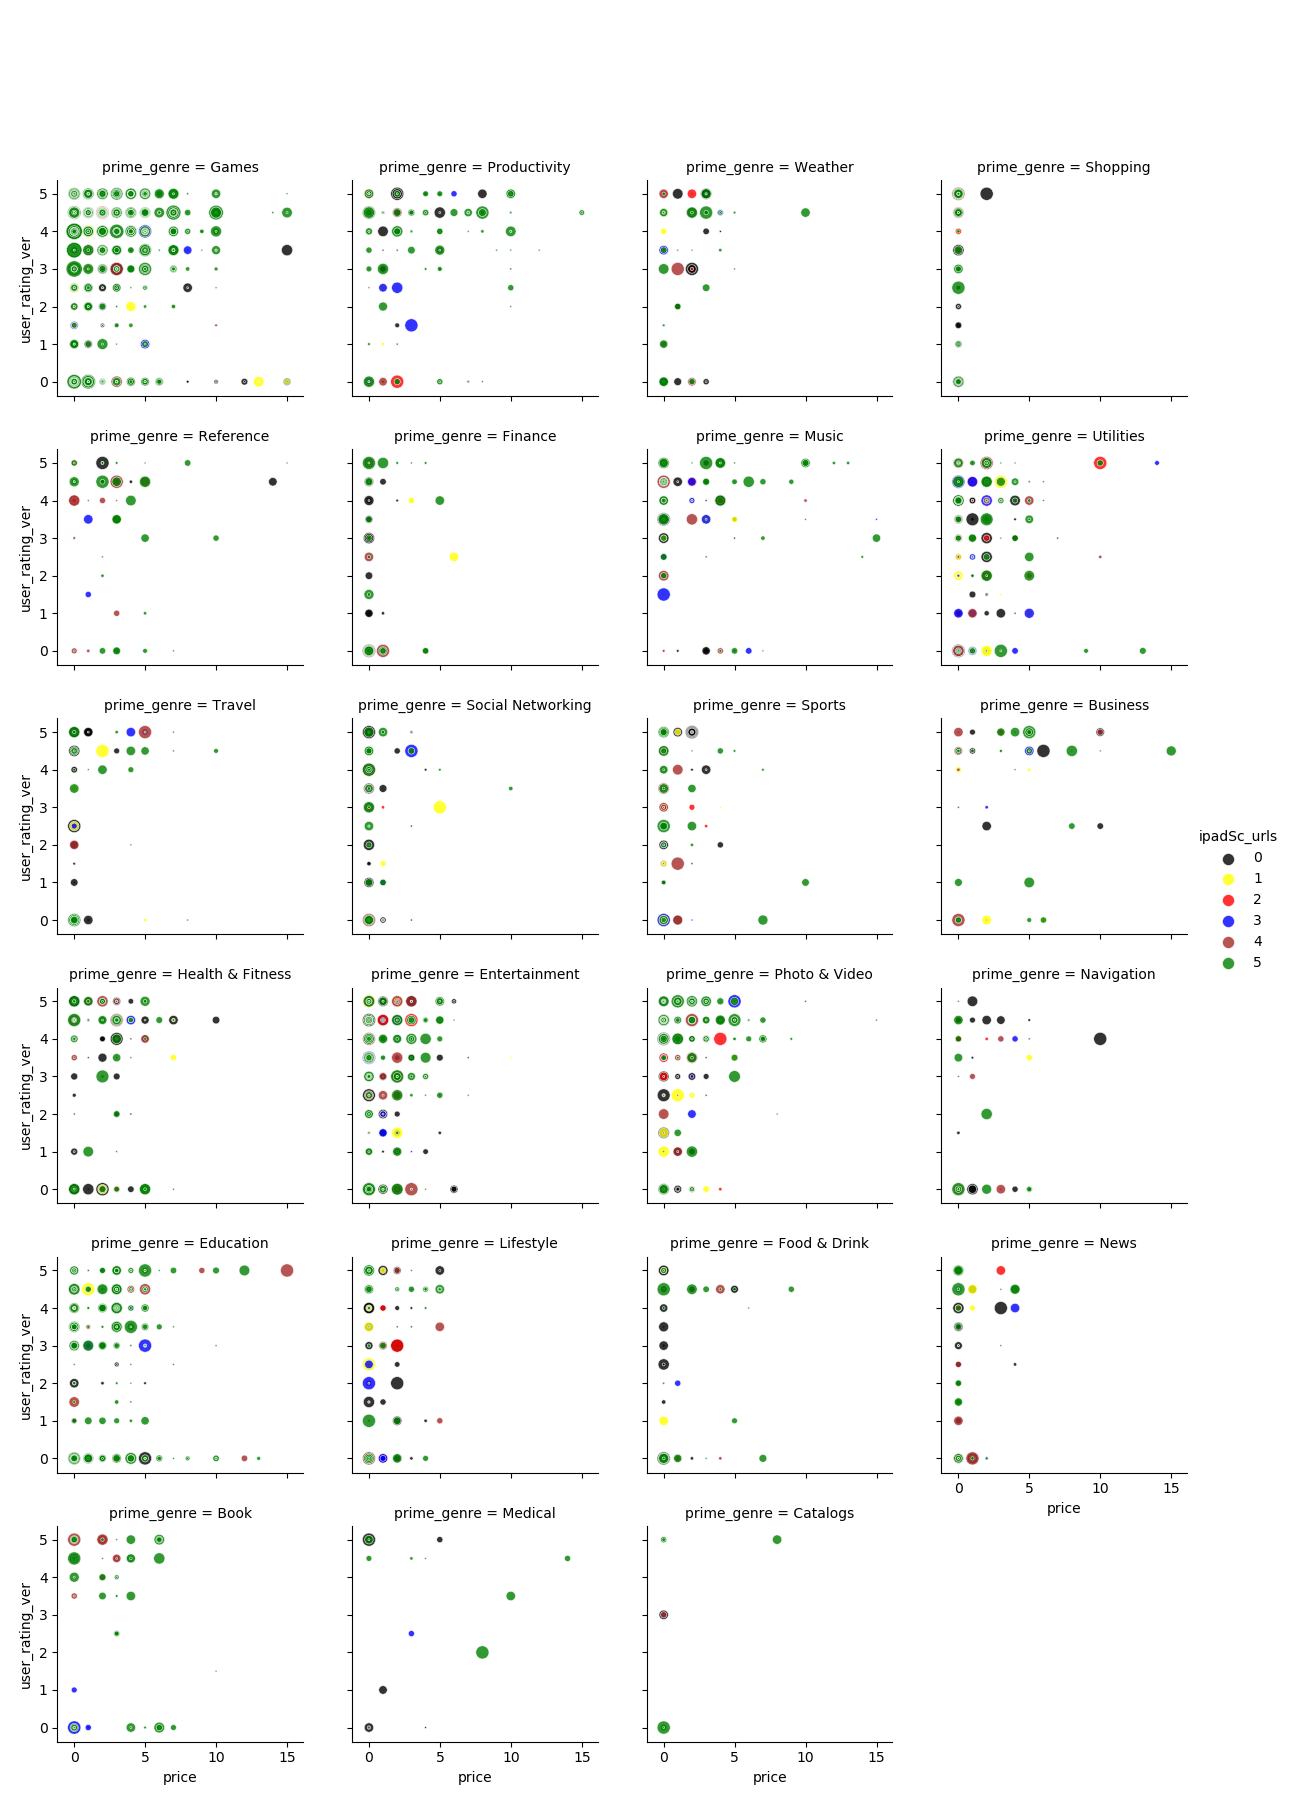

In [181]:
# %matplotlib inline
plt.figure(figsize=(30,20))
g = sns.FacetGrid(df[df["price"]<=15.0], col="prime_genre", hue='ipadSc_urls.num', col_wrap=4, 
                  palette=["black","yellow","red","blue", "brown", "green"])
                  

g.map(plt.scatter, "price", "user_rating_ver", alpha=0.8, 
      edgecolor='white', linewidth=0.5, s=df['lang.num']*2)

fig = g.fig 
fig.subplots_adjust(top=0.9, wspace=0.2)

l = g.add_legend(title='ipadSc_urls')
plt.show()

In [ ]:
# one_hot_data.head(2)

In [185]:
km_pazzo= KMeans(n_clusters=3, 
            init='random', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=rnd_state)

rex=df[df["prime_genre"]=="Games"]
rex=rex.drop(rex.columns[5:7],axis=1)

ziopino = scaler.fit_transform(rex)

y_km_pazzo = km_pazzo.fit_predict(ziopino)

NameError: name 'KMeans' is not defined

In [ ]:
ziopino=pd.DataFrame(ziopino)
ziopino.columns=rex.columns.values
ziopino["cluster"]=y_km_pazzo

In [ ]:
# df[df["prime_genre"]=="Games"].head(2)

In [ ]:
# ziopino.head(2)

In [ ]:
# plt.figure(figsize=(20,10))
# pd.plotting.parallel_coordinates(ziopino, 'cluster', color=('red', 'yellow', 'blue') )
# plt.show()

In [183]:
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

In [ ]:
# print(ziopino[0])

In [184]:
# create dendrogram
dendrogram = sch.dendrogram(sch.linkage(ziopino, method='ward'))
# create clusters
hc = AgglomerativeClustering(n_clusters=3, affinity = 'euclidean', linkage = 'ward')
# save clusters for chart
y_hc = hc.fit_predict(ziopino)

NameError: name 'ziopino' is not defined

In [ ]:
# y_hc

In [ ]:
# for i in range(0,8):
#     for j in range(0,8):
#         plt.scatter(ziopino[y_hc ==0,i], ziopino[y_hc == 0,j], s=100, c='red')
#         plt.scatter(ziopino[y_hc==1,i], ziopino[y_hc == 1,j], s=100, c='black')
#         plt.scatter(ziopino[y_hc ==2,i], ziopino[y_hc == 2,j], s=100, c='blue')
#         plt.show()


In [ ]:
# games_scaled_noout = scaler.fit_transform(div_genre_games_noout.iloc[:,:].values)
# games_scaled_noout.shape

In [ ]:
# # create dendrogram
# dendrogram1 = sch.dendrogram(sch.linkage(games_scaled_noout, method='ward'))
# # create clusters
# hc1 = AgglomerativeClustering(n_clusters=3, affinity = 'euclidean', linkage = 'ward')
# # save clusters for chart
# y_hc1 = hc.fit_predict(games_scaled_noout)

In [ ]:
# colors=["red", "black","blue"]
# for i in range(0,8):
#     for j in range(0,8):
#         for h in range(0,3):
#             plt.scatter(games_scaled_noout[y_hc1 ==h,i], games_scaled_noout[y_hc1 == h,j], s=100, c=colors[h])
#         plt.show()


In [ ]:
# games_scaled_noout_new=pd.DataFrame(games_scaled_noout)
# games_scaled_noout_new.columns=div_genre["Games"].columns.values
# games_scaled_noout_new["cluster"]=y_hc1

In [ ]:
# plt.figure(figsize=(20,10))
# pd.plotting.parallel_coordinates(games_scaled_noout_new, 'cluster', color=('red', 'yellow', 'blue') )
# plt.show()

In [ ]:
# salvo=(y_hc1!=y_km_games_scal_noout)

In [ ]:
# unique, counts = np.unique(salvo, return_counts=True)
# dict(zip(unique, counts))

In [ ]:
# # create dendrogram
# dendrogram2 = sch.dendrogram(sch.linkage(df_nocat_noout.iloc[:,:].values, method='ward'))
# # create clusters
# hc2 = AgglomerativeClustering(n_clusters=3, affinity = 'euclidean', linkage = 'ward')
# # save clusters for chart
# y_hc2 = hc.fit_predict(df_nocat_noout.iloc[:,:].values)

In [ ]:
# df_nocat_noout.head()

In [ ]:
# df_nocat_noout["cluster"]=y_hc2

In [ ]:
# unique, counts = np.unique(y_hc2!, return_counts=True)
# dict(zip(unique, counts))

In [ ]:
# df_nocat_noout.iloc[:,[0,3,4,5,6,7,8]]

In [ ]:
# plt.figure(figsize=(20,10))
# pd.plotting.parallel_coordinates(df_nocat_noout, 'cluster', color=('red', 'yellow', 'blue') )
# plt.show()